# Biweekly Report #2

# Claire Lu

# Implementing Dropout in a CNN for CIFAR-10

This week I will attempt to implement dropout to prevent the overfitting likely for deeper CNNs. Dropout is a regularization method that randomly "drops" neurons during training to prevent co-adaptation and subsequent overfitting. The dataset I will be using is the CIFAR-10 dataset.

I follow the algorithm for dropout provided by https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf.

dataset: CIFAR-10 is comprised of 50,000 training and 10,000 testing images, with 10 classes. Each image is a 32x32 pixel, 3 channel input.

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We begin with images \\( X \in \mathbb{R}^{H \times W \times C} \\).

in this case: \\( H = W = 32 \\), the RBG channels are \\( C = 3 \\), and each pixel \\( X(i,j,c) \in [0, 255] \\)

I normalize each image so pixels are in range \\([-1,1]\\) and have mean, std = (0,1)


In [2]:
#convert to tensorand normalize to mean=0, std=1 per channel
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
#load dataset and indiv classes
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Visualization of a subset of training images ( unnormalizing just to display tensors correctly)

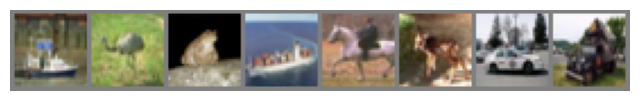

 ship  bird  frog  ship horse  deer   car truck


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join(f'{classes[labels[j]]:>5s}' for j in range(8)))


### CNN
I'll first compare CNN performance without dropout. I'll use the network class from the built in torch. This CNN extracts spatial hierarchies via convolution + pooling and maps them to class. There are two convolutional layers, the first taking in the 3 RBG input channels anf outputting 32 filters. For \\( X \in \mathbb{R}^{32 \times 32 \times 3} \\) -> \\( X \in \mathbb{R}^{32 \times 32 \times 32} \\). After the second convolutional later, \\( X \in \mathbb{R}^{32 \times 32 \times 64} \\). Max pooling occurs over 2x2 windows, reducing by a factor of 2. This reduces dimensionality from \\( X \in \mathbb{R}^{32 \times 32 \times 64} \\) -> \\( X \in \mathbb{R}^{16 \times 16 \times 3} \\) -> \\( X \in \mathbb{R}^{8 \times 8 \times 64} \\).

Each convolution computes:

$$
Y_{ij}^{(k)} = \sum_{u,v,c} W_{uvc}^{(k)} X_{i+u,j+v,c} + b^{(k)}
$$

followed by

$$
A^{(k)} = ReLU(Y^{(k)}).
$$

Pooling reduces resolution by taking:

$$
P_{ij} = \max_{u,v \in \text{window}} A_{i+u,j+v}.
$$
After the final pooling, we have feature maps

$$
A \in \mathbb{R}^{C \times H' \times W'}.
$$

Flattening converts this to a vector

$$
x \in \mathbb{R}^d, \quad d = C \cdot H' \cdot W'.
$$



In [4]:
class SimpleCNN_NoDropout(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1  = nn.Linear(64*8*8, 256)
        self.fc2  = nn.Linear(256, num_classes) ##256 neurons to produce raw class score

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)



In [5]:
model_no_dropout = SimpleCNN_NoDropout().to(device)
print(model_no_dropout)


SimpleCNN_NoDropout(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


We can see each input img after convolution/pooling are flattened to 4096 (64 x 8 x 8) and outputs a 256 dim vector, and after the final classification layer takes 256 and outputs 10 (aka 1 per the 10 classes in CIFAR-10).

Each convolutional filter learns to detect a specific visual pattern (edges, colors, textures). Taking the first convolution layer of the CNN and extracting its learned filters, and then normalizing pixel values to [0,1] for visualization makes it so I can visualize the filtered patterns. This should visualize both the filters and feature maps for the model.

In [6]:
def show_filters_and_maps(conv_layer, feature_maps, img, fmap_indices=[0,1,2,3,4,5]):
    weights = conv_layer.weight.detach().cpu().numpy()
    w_min, w_max = weights.min(), weights.max()#normalize
    out_ch = weights.shape[0]
    n_show = min(6, out_ch)
    plt.figure(figsize=(12,2))

    # filter
    for i in range(n_show):
        filt_img = (weights[i] - w_min) / (w_max - w_min)
        filt_vis = np.transpose(filt_img, (1,2,0))
        plt.subplot(2, n_show, i+1)
        plt.imshow(filt_vis)
        plt.title(f"Filter {i}")
        plt.axis('off')

    #activation map
    fmap = feature_maps[0].detach().cpu().numpy()
    for idx_i, fmap_idx in enumerate(fmap_indices[:n_show]):
        plt.subplot(2, n_show, n_show + idx_i + 1)
        plt.imshow(fmap[fmap_idx])
        plt.title(f"Map {fmap_idx}")
        plt.axis('off')
    plt.show(block=True)

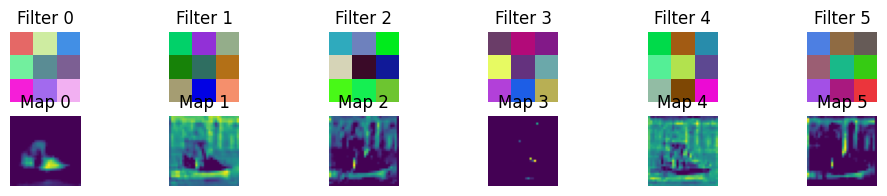

In [7]:
img0 = images[0:1].to(device)   # send image to same device as model
with torch.no_grad():
    conv1_out = F.relu(model_no_dropout.conv1(img0))

show_filters_and_maps(model_no_dropout.conv1, conv1_out, img0)


We can see that the filters displayed in the top row correspond to small 3×3×3 weight tensors, each showing what convolutional layer has learned to detect from the input images. Since it is the first layer, it will resemble a basic edge and color detector visually. When these filters are applied to an input image on the bottom row, they produce the feature maps. It shows the regions of the image where a specific filter responds strongly. The bright regions in the feature maps indicate strong activations, meaning those are parts of the image that match the original, while darker regions correspond to weaker or no activation.


In [8]:
with torch.no_grad():
    logits_single = model_no_dropout(images[0:1].to(device))
    probs = F.softmax(logits_single, dim=1).cpu().numpy()[0]

print("softmax:", np.round(probs, 3))
print("predicted class:", np.argmax(probs))


softmax: [0.097 0.1   0.101 0.099 0.108 0.097 0.097 0.097 0.108 0.096]
predicted class: 4


Each element of the softmax vector corresponds to the model’s estimated probability for one of the 10 CIFAR-10 classes. The probablities are all rather low at around 10% since the model hasn't been trained yet. After training, dropout will regularize the fully connected layers and improve the softmax probablities.


### Dropout

I'll define two dropout implementations: one with standard element-wise dropout where each neuron is dropped independently of each other, and another with spatial dropout where entire feature maps and channels are dropped at once. In element-wise dropout, each element is kept(1) or dropped (0), which is sampling from a Bernuolli(p_keep) distribution for each element. In spatial dropout, it drops entire features, so all pixels in a channel are dropped (0). For regularization, we can use spatial dropout when neighboring pixels are highly correlated such that dropping individual ones wouldn't help.

\\[
z_i \sim \text{Bernoulli}(p),
\\]

where \\( p \\) is keep probability (the probability a unit is retained).

Element wise dropout is applied for fully connected layers, while spatial dropout is applied for convolutional layers (since entire feature maps dropped at once).


In [9]:
def my_dropout(x, p_keep=0.5, training=True):
    if (not training) or p_keep==1.0: return x
    mask = (torch.rand_like(x) < p_keep).float()
    return (x * mask) / p_keep

def my_spatial_dropout(x, p_keep=0.75, training=True):
    if (not training) or p_keep==1.0: return x
    B,C,_,_ = x.shape
    mask = (torch.rand((B,C,1,1), device=x.device) < p_keep).float()
    return (x * mask) / p_keep


In [10]:
x = torch.ones((1000,100))
p = 0.5
y = my_dropout(x, p_keep=p, training=True)
print("Observed drop fraction:", (y==0).float().mean().item(), "Expected:", 1-p)


Observed drop fraction: 0.5011199712753296 Expected: 0.5


When p =0.5, approximately 50% of the elements are dropped which matches the expected drop rate.

### CNN with dropout
Here we inject dropout into the CNN with keep probabilities:
- p_in = Input (keep 0.8), dropping 0.2
- p_conv = Convolutional feature maps (keep 0.75), dropping 0.25
- p_fc = Fully connected layers (keep 0.5), dropping 0.5 of neurons in fully connected layer

We use spatial dropout channel-wise, keeping each feature map with prob = 0.75.

With hyperparameter \\( p_{\text{conv}} = 0.75 \\):

\\[
\tilde{x}_{b,c,:,:} = \frac{x_{b,c,:,:} \, z_c^{(\text{conv})}}{0.75}, 
\quad z_c^{(\text{conv})} \sim \text{Bernoulli}(0.75)
\\]

We use elementwise dropout after the fully connected layer, keeping each neuron with prob =0.5

\\[
\tilde{h}_i = \frac{h_i \, z_i^{(\text{fc})}}{0.5}, 
\quad z_i^{(\text{fc})} \sim \text{Bernoulli}(0.5)
\\]


In [11]:
class SimpleCNN_CustomDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.p_in, self.p_conv, self.p_fc = 0.8, 0.75, 0.5
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*8*8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = my_dropout(x, self.p_in, self.training)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = my_spatial_dropout(x, self.p_conv, self.training)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = my_dropout(x, self.p_fc, self.training)
        return self.fc2(x)


In [12]:
model_custom = SimpleCNN_CustomDropout().to(device)
print(model_custom)


SimpleCNN_CustomDropout(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


The convolutional netowrk should be the same kernels as previous. Dropout introduces stochasticity only during the training and it helps the model avoid overfitting by having random subsets of neurons learn interdepently of each other. Random neurons (activations) are zeroed out based on the keep values, with resultant one scaled to (1/p_keep).

In [13]:
images, _ = next(iter(trainloader))
images = images.to(device)
model_custom.train()
out_train = model_custom(images[:8])
model_custom.eval()
out_eval = model_custom(images[:8])
print("Output (training mode):", out_train[0][:5])
print("Output (eval mode):", out_eval[0][:5])


Output (training mode): tensor([ 0.0774, -0.1340,  0.0941,  0.0843,  0.0151], device='cuda:0',
       grad_fn=<SliceBackward0>)
Output (eval mode): tensor([ 0.0516, -0.0540,  0.0851,  0.0149,  0.0122], device='cuda:0',
       grad_fn=<SliceBackward0>)


The resulting activations are noisier and have lower magnitude. In evaluation, the outputs are smoother and higher maginitude because the neurons are contributing. Variation between outputs shows dropout being stochastic (and lower magnitude in training is due to the neuron dropout). The scaling during inference The resulting activations are noisier and have lower magnitude. In evaluation, the outputs are smoother and higher maginitude because the neurons are contributing. Variation between outputs shows dropout being stochastic (and lower magnitude in training is due to the neuron dropout). The scaling during inference reduces the overfitting and improves generalization once the model is trained.

### Testing and Comparison

Here we'll run a few epochs of training to visualize the effect of dropout and compare it with no dropout. The expected outcome with few runs would be better performance without due to less loss, but still demonstrates the neuron drop of dropout.

In [14]:
import torch.optim as optim

model_no_dropout = SimpleCNN_NoDropout().to(device)
model_custom = SimpleCNN_CustomDropout().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_no_dropout = optim.Adam(model_no_dropout.parameters(), lr=0.001, weight_decay=1e-4)
optimizer_custom = optim.Adam(model_custom.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 25
train_losses_no, train_losses_drop = [], []

for epoch in range(num_epochs):
    model_no_dropout.train()
    model_custom.train()
    running_no, running_drop = 0.0, 0.0

    for imgs, labels in trainloader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer_no_dropout.zero_grad()
        out_no = model_no_dropout(imgs)
        loss_no = criterion(out_no, labels)
        loss_no.backward()
        optimizer_no_dropout.step()
        running_no += loss_no.item()

        optimizer_custom.zero_grad()
        out_drop = model_custom(imgs)
        loss_drop = criterion(out_drop, labels)
        loss_drop.backward()
        optimizer_custom.step()
        running_drop += loss_drop.item()

    train_losses_no.append(running_no / len(trainloader))
    train_losses_drop.append(running_drop / len(trainloader))
    print(f"Epoch {epoch+1}/{num_epochs} - NoDrop: {train_losses_no[-1]:.4f}, Dropout: {train_losses_drop[-1]:.4f}")



Epoch 1/25 - NoDrop: 1.2252, Dropout: 1.5884
Epoch 2/25 - NoDrop: 0.8537, Dropout: 1.2848
Epoch 3/25 - NoDrop: 0.6915, Dropout: 1.1739
Epoch 4/25 - NoDrop: 0.5532, Dropout: 1.1184
Epoch 5/25 - NoDrop: 0.4281, Dropout: 1.0685
Epoch 6/25 - NoDrop: 0.3215, Dropout: 1.0378
Epoch 7/25 - NoDrop: 0.2178, Dropout: 1.0092
Epoch 8/25 - NoDrop: 0.1657, Dropout: 0.9850
Epoch 9/25 - NoDrop: 0.1194, Dropout: 0.9591
Epoch 10/25 - NoDrop: 0.1062, Dropout: 0.9442
Epoch 11/25 - NoDrop: 0.0959, Dropout: 0.9181
Epoch 12/25 - NoDrop: 0.0904, Dropout: 0.9095
Epoch 13/25 - NoDrop: 0.0750, Dropout: 0.8917
Epoch 14/25 - NoDrop: 0.0819, Dropout: 0.8823
Epoch 15/25 - NoDrop: 0.0739, Dropout: 0.8716
Epoch 16/25 - NoDrop: 0.0696, Dropout: 0.8581
Epoch 17/25 - NoDrop: 0.0772, Dropout: 0.8478
Epoch 18/25 - NoDrop: 0.0608, Dropout: 0.8381
Epoch 19/25 - NoDrop: 0.0705, Dropout: 0.8229
Epoch 20/25 - NoDrop: 0.0625, Dropout: 0.8154
Epoch 21/25 - NoDrop: 0.0629, Dropout: 0.8083
Epoch 22/25 - NoDrop: 0.0587, Dropout: 0.80

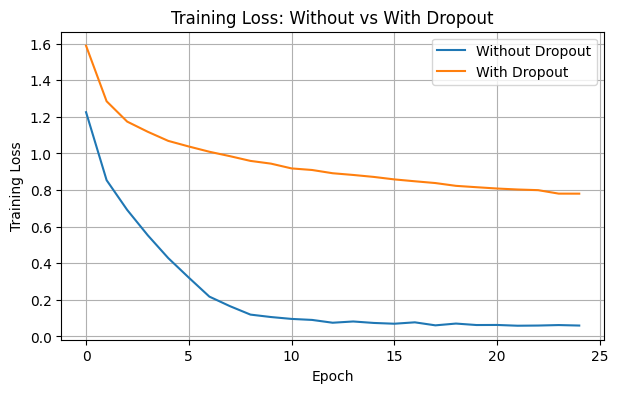

In [15]:
plt.figure(figsize=(7,4))
plt.plot(train_losses_no, label='Without Dropout')
plt.plot(train_losses_drop, label='With Dropout')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss: Without vs With Dropout')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
def evaluate(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in testloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

acc_no = evaluate(model_no_dropout)
acc_drop = evaluate(model_custom)

print(f"Test Accuracy (No Dropout): {acc_no:.2f}%")
print(f"Test Accuracy (With Dropout): {acc_drop:.2f}%")


Test Accuracy (No Dropout): 72.96%
Test Accuracy (With Dropout): 71.48%


After a brief training period, dropout is demonstrated to be similar if not lower initially, but with longer training should yield better generalization. Loss is initially high with dropout, but will converge better as epochs and training period increases.

### Future
In the future, I can explore the effects of not normalizing the data such that the mean and standard deviation are not centered around (0,1). This will likely complicate channel variation. Additionally, I can train for a larger amount of epochs till full convergance to fully view the true accuracy. I should also implement validation and visualize confidence to see how dropout has less overfit predictions, after more intensive training periods.